# Surrogate Construction for Genz Functions: BCS

This notebook constructs a PC surrogate for Genz functions and gives the normalized root mean square error between the surrogate and the actual function. Both the Genz function and PCE are defined on [-1,1].

In [1]:
import numpy as np
import math  
from scipy.stats import qmc
import pandas as pd

import PyUQTk.pce as uqtkpce
import PyUQTk.PyPCE.pce_tools as pce_tools
from PyUQTk.utils.func import *

PyMC is required for some of the MCMC postprocessing codes.
Will proceed without, but some convergence tests will not be available.


We define our input parameters. BCS is best for undetermined models and/or large basis sets.

In [2]:
# PC parameters
nord = 8            # Order of the final PCE basis
ndim = 2            # Number of dimensions
pc_type = "LU"      # Polynomial type
pc_alpha = 0.0      # Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs
pc_beta = 1.0       # Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs

# BCS parameters
niter = 3                                        # Number of iterations to run, must be > 0
eta = 1/np.power(10,[i for i in range(1,16)])    # Threshold for stopping the algorithm
ntry = 5                                         # Number of splits for cross-validation of the retained basis terms 
eta_folds = 5                       # Number of folds to use for eta cross-validation                          
mindex_growth = 'nonconservative'   # Method for basis growth; options are "conservative," "nonconservative," or None
regparams = None                    # Regularization weights (provide an array or value); if None, they are autopopulated
sigma = 1e-8                        # Inital noise variance; updated in BCS
trval_frac = None                   # Fraction of total data to use in each split
npccut = None                       # Maximum number of PC coefficients to retain
pcf_thr = None                      # Minimum value (by magnitude) for PC coefficients
verbose = 0                         # Flag for print statements
eta_plot = False                    # Flag for plotting possible etas by RMSEs during optimization

# Model Choice 
model = 'genz_osc'   # Choices are 'genz_osc', 'genz_exp', 'genz_cont','genz_gaus','genz_cpeak', 'genz_ppeak'

We randomly generate training and testing data.

In [3]:
# PC model with a full basis set
pc_model =  uqtkpce.PCSet("NISPnoq", nord, ndim, pc_type, pc_alpha, pc_beta)

# Random number generator
rng = qmc.LatinHypercube(d=ndim, seed=42)

#Training
nTrain = int(pc_model.GetNumberPCTerms()*0.75) # Number of training samples
x_train = 2*rng.random(n=nTrain)-1
y_train = func(x_train, model, np.ones(ndim+1))

#Testing
nTest = 10000  # Number of testing samples
x_test = 2*rng.random(n=nTest)-1
y_test = func(x_test, model, np.ones(ndim+1))

We perform BCS.

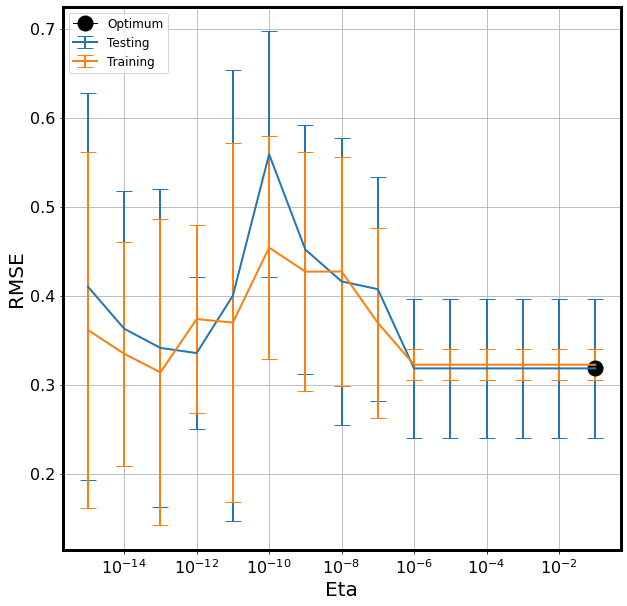

In [6]:
# PC object with the starting basis

# determine order of the starting basis
if mindex_growth == None:
    start_ord = nord # if no basis growth, order of the final basis = order of the starting basis
else:
    start_ord = nord-niter+1 # if basis growth, shrink starting basis to allow for growth niter-1 times
    
pc_start = uqtkpce.PCSet("NISPnoq", start_ord, ndim, pc_type, pc_alpha, pc_beta)

# Determine coefficients through BCS
pc_final, c_k = pce_tools.UQTkBCS(pc_start, x_train, y_train, niter, eta, ntry, eta_folds, mindex_growth, regparams, sigma, trval_frac, npccut, pcf_thr, verbose, eta_plot)

Finally, we calculate the error.

In [5]:
# Evaluate the PCE
pce_evals = pce_tools.UQTkEvaluatePCE(pc_final, c_k, x_test)

# Calculate error metric
MSE = np.square(np.subtract(y_test, pce_evals)).mean()
NRMSE=math.sqrt(MSE)/np.linalg.norm(y_test)
print("The NRMS error between a", ndim, "-dimensional", model, "function and a BCS-based PC surrogate of \
order", nord, "is")
NRMSE

The NRMS error between a 2 -dimensional genz_osc function and a BCS-based PC surrogate of order 8 is


0.005482941961785882